In [1]:
from libraries import *

# Simulation Setup

In [3]:
# Parameters for simulation
ITER                    = 5                                # Iteration count
SIMULATION_INTERVAL     = 50                               # Simulation interval per iteration
TOT_SIMULATION_INTERVAL = max(100, SIMULATION_INTERVAL)    # Total simulation interval
T_START                 = 50                                # Starting time step
LIMIT                   = 0.5                              # For use with the DTR algorithm
PENALTY                 = 0                                # Penalty for SR rejection

SYNTH_BRAIN             = 0                                # Whether to choose the synthetic topology (0) or BRAIN (1)

gp.setParam("OutputFlag", 0)                               # Disables Gurobi logs (Affects all models created afterward)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-18


### 5G Infrastructure Setup

In [5]:
V_P_S = V_P_R = E_P = E_P_l = L = L_pqi = []
V_P_S, V_P_R, E_P, E_P_l, L, L_pqi = init_setup_synth() if SYNTH_BRAIN == 0 else init_setup_brain()

### Slice Request Setup

In [7]:
# Initialize slice types and probabilities
sr_types = create_sr_resources()
sr_probs = [0.7, 0.15, 0.1, 0.05]  # Probabilities for each type

# Generate SR list
sr_list, sr_type_list = init_setup_sr(ITER, TOT_SIMULATION_INTERVAL, sr_types, sr_probs)

In [8]:
print(len(sr_type_list))

500


### Infrastructure Graph

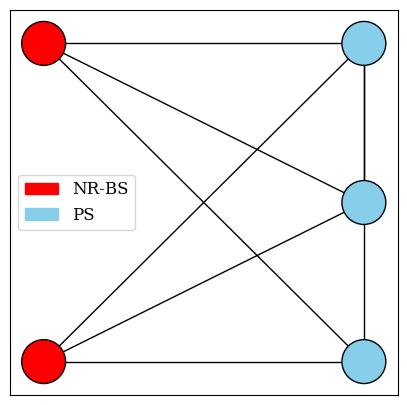

In [10]:
plot_synth(V_P_S, V_P_R, E_P) if SYNTH_BRAIN == 0 else plot_brain(V_P_S, V_P_R, E_P)

### Data Templates

In [12]:
data = {}

algs = ["opt", "iar", "dtr", "rnr", "nis", "cis", "fgr"]
for a in algs:
    data[a] = {
        "profit":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "violat":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 5)), ## 5 for Total (0), Radio (1), Bandwidth (2), MIPS (3), and Delay (4)
        "migrat":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "deploy":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 4)),
        "overhe":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 4)),
        "reseff":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 4)),
        "reject":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 3)),
        "time":    np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "vars":    [[{} for _ in range(T_START+SIMULATION_INTERVAL)] for _ in range(ITER)],
        "feasib":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "timeou":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "R_t":     [[[] for _ in range(T_START+SIMULATION_INTERVAL)] for _ in range(ITER)],
        "X_t":     [[] for _ in range(ITER)],
        "Y_t":     [[] for _ in range(ITER)]
    }

fgr_alg_list = [[0 for _ in range(T_START+SIMULATION_INTERVAL)] for _ in range(ITER)]

data_loaded = copy.deepcopy(data)

# Running the Simulation

### Saved Data Reuse (from previous runs)

In [15]:
keys = ["profit", "violat", "migrat", "deploy", "overhe", "reseff", "reject", "time", "vars", "feasib", "timeou", "R_t", "X_t", "Y_t"]
data_loaded = {}
if T_START > 0:
    for a in algs:
        # Load the lists from the file
        with open(f'saved_data/{a}.pkl', 'rb') as file:
            data_loaded = pickle.load(file)
        
        data[a]["profit"][:, :T_START]    = data_loaded["profit"][:, :T_START]
        data[a]["violat"][:, :T_START, :] = data_loaded["violat"][:, :T_START, :]
        data[a]["migrat"][:, :T_START]    = data_loaded["migrat"][:, :T_START]
        data[a]["deploy"][:, :T_START, :] = data_loaded["deploy"][:, :T_START, :]
        data[a]["overhe"][:, :T_START, :] = data_loaded["overhe"][:, :T_START, :]
        data[a]["reseff"][:, :T_START, :] = data_loaded["reseff"][:, :T_START, :]
        data[a]["reject"][:, :T_START, :] = data_loaded["reject"][:, :T_START, :]
        data[a]["time"][:, :T_START]      = data_loaded["time"][:, :T_START]
        data[a]["feasib"][:, :T_START]    = data_loaded["feasib"][:, :T_START]
        data[a]["timeou"][:, :T_START]    = data_loaded["timeou"][:, :T_START]
        data[a]["X_t"]                    = data_loaded["X_t"] ## Last mappings for each iteration (To save storage + time)
        data[a]["Y_t"]                    = data_loaded["Y_t"] ## Last mappings for each iteration (To save storage + time)
        
        # Handle dictionaries and lists separately
        for i in range(ITER):
            for t in range(T_START):
                data[a]["vars"][i][t] = data_loaded["vars"][i][t]
                data[a]["R_t"][i][t]  = data_loaded["R_t"][i][t]

[<data.sr object at 0x00000194251E8510>, <data.sr object at 0x00000194251E8B10>, <data.sr object at 0x00000194251E8CD0>, <data.sr object at 0x00000194251E8FD0>, <data.sr object at 0x00000194251E9390>, <data.sr object at 0x00000194251E9750>, <data.sr object at 0x00000194251E9AD0>, <data.sr object at 0x00000194251E9E10>, <data.sr object at 0x00000194251EA1D0>]


### Simulation Run Template

In [17]:
def run_simulation(alg, ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, func, limit=None):
    """
    Generic simulation function for different algorithms
    
    Parameters:
        alg (str): "fgr", "opt", "iar", "dtr", "rnr"
        ITER (int): Number of iterations
        SIMULATION_INTERVAL (int): Simulation time steps
        sr_list (list): Service request list
        V_P_S, V_P_R, E_P, E_P_l, L, L_pqi: Network elements
        func (function): Optimization function to call (opt_iter or dtr_iter)
        limit (float, optional): Limit parameter for "dtr" algorithm
    """
    file_path = f'saved_data/{alg}.pkl'

    for iter in range(ITER):
        if T_START == 0:
            m = gp.Model("e2esliceiso")
            if alg == "fgr":
                m.write(f'saved_model/model_backup_fgr_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_opt_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_iar_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_dtr_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_rnr_{iter}.mps')
            else:
                m.write(f'saved_model/model_backup_{alg}_{iter}.mps')
        
        for t in range(T_START, T_START+SIMULATION_INTERVAL):
            print(f"\niteration: {iter}, Time step: {t}")
            
            prev_profit = data[alg]["profit"][iter][t-1] if t > 0 else 0
            prev_R_t    = data[alg]["R_t"][iter][t-1]    if t > 0 else []
            X_t         = data[alg]["X_t"][iter]         if t > 0 else []
            Y_t         = data[alg]["Y_t"][iter]         if t > 0 else []
            
            if alg == "fgr":    # "dtr" requires an additional limit parameter
                result, fgr_alg_list[iter][t], X_t, Y_t = func(limit, prev_profit, iter, t, sr_list[iter * TOT_SIMULATION_INTERVAL + t], prev_R_t, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, X_t, Y_t)
            elif alg == "dtr":  # "dtr" requires an additional limit parameter + f_fgr = 0
                result, X_t, Y_t = func(limit, prev_profit, iter, t, sr_list[iter * TOT_SIMULATION_INTERVAL + t], prev_R_t, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, 0, X_t, Y_t)
            else:
                result, X_t, Y_t = func(prev_profit, iter, t, sr_list[iter * TOT_SIMULATION_INTERVAL + t], prev_R_t, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, 0, X_t, Y_t)
            
            keys = ["profit", "violat", "migrat", "deploy", "overhe", "reseff", "reject", "time", "vars", "feasib", "timeou", "R_t"]
            if result[9] == 1:  # feasible
                for idx_k, k in enumerate(keys):
                    data[alg][k][iter][t] = result[idx_k]
                data[alg]["X_t"][iter]    = X_t
                data[alg]["Y_t"][iter]    = Y_t
            else:  # infeasible
                if t > 0:
                    for idx_k, k in enumerate(keys):
                        data[alg][k][iter][t] = data[alg][k][iter][t-1]
                    data[alg]["reject"][iter][t] = result[6]
                    data[alg]["time"][iter][t]   = result[7]
                    data[alg]["feasib"][iter][t] = result[9]
                    data[alg]["timeou"][iter][t] = result[10]
                    data[alg]["profit"][iter][t] = data[alg]["profit"][iter][t-1] - PENALTY
    
    # Save updated data
    with open(file_path, 'wb') as file:
        pickle.dump(data[alg], file)
    
    return data

### OPT

In [19]:
data = run_simulation("opt", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, opt_iter)


iteration: 0, Time step: 50
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | OPT                 |
+-------------------------+---------------------+
| Request Isolation Level | (2, 0)              |
+-------------------------+---------------------+
| Allocation Time         | 0.05397679999805405 |
+-------------------------+---------------------+
| Feasible                | 0                   |
+-------------------------+---------------------+
| Timeout                 | 1                   |
+-------------------------+---------------------+
profit
violat
migrat
deploy
overhe
reseff
reject
time
vars
feasib
timeou
R_t

iteration: 0, Time step: 51
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | OPT                 |
+--------------

### DTR

In [21]:
data = run_simulation("dtr", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, dtr_iter, limit=LIMIT)


iteration: 0, Time step: 50
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | DTR                 |
+-------------------------+---------------------+
| Request Isolation Level | (2, 0)              |
+-------------------------+---------------------+
| Allocation Time         | 0.03903630000058911 |
+-------------------------+---------------------+
| Feasible                | 0                   |
+-------------------------+---------------------+
| Timeout                 | 1                   |
+-------------------------+---------------------+
profit
violat
migrat
deploy
overhe
reseff
reject
time
vars
feasib
timeou
R_t

iteration: 0, Time step: 51
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | DTR                 |
+--------------

### RNR

In [23]:
data = run_simulation("rnr", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, rnr_iter)


iteration: 0, Time step: 50
X_t:[[[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]], [[0.0, 0.0, 1.0]]]
+-------------------------+----------------------+
| Category                | Value                |
+=========================+======================+
| Algorithm               | RNR                  |
+-------------------------+----------------------+
| Request Isolation Level | (2, 0)               |
+-------------------------+----------------------+
| Allocation Time         | 0.014583899999706773 |
+-------------------------+----------------------+
| Feasible                | 0                    |
+-------------------------+----------------------+
| Timeout                 | 0                    |
+-------------------------+----------------------+
profit
violat
migrat
deploy
overhe
reseff
reject
time
vars
feasib
timeou
R_t

iteration: 0, Time step: 51
X_t:[[[

### IAR

In [25]:
data = run_simulation("iar", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, iar_iter)


iteration: 0, Time step: 50
infeasible: Checked all possible NR-BSs. No remaining NR-BS for mapping RU <data.ru object at 0x0000019419E8D690> of SR <data.sr object at 0x0000019419E8D450>
end_time1-start_time1:0.006763900000805734
Infeasible Problem
+-------------------------+---------+
| Category                | Value   |
+=========================+=========+
| Algorithm               | IAR     |
+-------------------------+---------+
| Request Isolation Level | (2, 0)  |
+-------------------------+---------+
| Allocation Time         | 0       |
+-------------------------+---------+
| Feasible                | 0       |
+-------------------------+---------+
| Timeout                 | 0       |
+-------------------------+---------+
profit
violat
migrat
deploy
overhe
reseff
reject
time
vars
feasib
timeou
R_t

iteration: 0, Time step: 51
end_time1-start_time1:0.021046599998953752
+-------------------------+---------------------+
| Category                | Value               |
+======

### 5Guard

In [27]:
data = run_simulation("fgr", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, fgr_iter, limit=LIMIT)


iteration: 0, Time step: 50
infeasible: Checked all possible NR-BSs. No remaining NR-BS for mapping RU <data.ru object at 0x0000019436D72B50> of SR <data.sr object at 0x0000019436D72910>
end_time1-start_time1:0.0061121999970055185
Infeasible Problem
X_t:[[[-0.0, -0.0, 1.0]], [[1.0, -0.0, -0.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[1.0, -0.0, -0.0]], [[-0.0, -0.0, 1.0]], [[1.0, -0.0, -0.0]], [[-0.0, -0.0, 1.0]], [[1.0, -0.0, -0.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[1.0, -0.0, -0.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[1.0, -0.0, -0.0]], [[1.0, -0.0, -0.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -0.0, 1.0]], [[-0.0, -

### NIS

In [29]:
data = run_simulation("nis", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, nis_iter)


iteration: 0, Time step: 50
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | NIS                 |
+-------------------------+---------------------+
| Request Isolation Level | (2, 0)              |
+-------------------------+---------------------+
| Allocation Time         | 0.09245499999815365 |
+-------------------------+---------------------+
| Feasible                | 0                   |
+-------------------------+---------------------+
| Timeout                 | 1                   |
+-------------------------+---------------------+
profit
violat
migrat
deploy
overhe
reseff
reject
time
vars
feasib
timeou
R_t

iteration: 0, Time step: 51
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | NIS                 |
+--------------

### CIS

In [31]:
data = run_simulation("cis", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, cis_iter)


iteration: 0, Time step: 50
+-------------------------+----------------------+
| Category                | Value                |
+=========================+======================+
| Algorithm               | CIS                  |
+-------------------------+----------------------+
| Request Isolation Level | (2, 0)               |
+-------------------------+----------------------+
| Allocation Time         | 0.006313099998806138 |
+-------------------------+----------------------+
| Feasible                | 0                    |
+-------------------------+----------------------+
| Timeout                 | 0                    |
+-------------------------+----------------------+
profit
violat
migrat
deploy
overhe
reseff
reject
time
vars
feasib
timeou
R_t

iteration: 0, Time step: 51
+-------------------------+----------------------+
| Category                | Value                |
+=========================+======================+
| Algorithm               | CIS                  

# Results

### Retrieving the saved data

In [34]:
for a in algs:
    # Load the lists from the file
    with open(f'saved_data/{a}.pkl', 'rb') as file:
        data_loaded[a] = pickle.load(file)

### Find the data average

In [36]:
data_avg = copy.deepcopy(data_loaded)

kpis = ["profit", "violat", "migrat", "deploy", "overhe", "reseff", "reject", "time"]

for a in algs:
    for k in kpis:
        data_avg[a][k] = np.sum(data_loaded[a][k], axis=0) / ITER

### Plot Settings

In [81]:
plt.rcParams['font.family']  = 'DeJavu Serif'
plt.rcParams['font.serif']   = ['Times New Roman']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

# Constants
bar_width       = 0.1
markevery       = int((T_START + SIMULATION_INTERVAL) / 5)
linewidth       = 5
marker_size     = 17
markeredgewidth = 4
step            = markevery  # Error bars frequency

tick_label_size, legend_font_size, xlabel_font_size, ylabel_font_size = 25, 18, 23, 23

kpi1  = ["reject"]
kpis2 = ["profit", "migrat"]
kpis3 = ["violat", "deploy", "overhe", "reseff"]
kpi4  = ["time"]
kpi5  = ["isol"]

xpoints = range(0, T_START+SIMULATION_INTERVAL)
ypoints = data_avg.copy()
yerrors_low  = {a: {k: ypoints[a][k]-np.min(data_loaded[a][k], axis=0) for k in kpis2+kpis3+kpi4} for a in algs}  # Lower bound errors
yerrors_high = {a: {k: np.max(data_loaded[a][k], axis=0)-ypoints[a][k] for k in kpis2+kpis3+kpi4} for a in algs}  # Upper bound errors

plot_titles = [
    ('Isolation Level', 'Slice Admission (%)'),
    ('$\it{t}$',        'Profit'),
    ('$\it{t}$',        'Cumulative Migration'),
    ('$\it{t}$',        'Aggregate Violation Cost'),   
    ('$\it{t}$',        'Aggregate Deployment Cost'),
    ('$\it{t}$',        'Aggregate Overhead Cost'),
    ('$\it{t}$',        'Resource Efficiency (%)'),
    ('$\it{t}$',        'Average Isolation Level'),
]

# Define a mapping of algorithms to their properties (color, marker, linestyle, pattern)
properties_map = {
    'opt': {'color': '#EE0000', 'marker': 'v', 'linestyle': '-', 'pattern': '\\', 'legend': 'OPT'},
    'iar': {'color': '#6E8EE6', 'marker': 'h', 'linestyle': '-', 'pattern': 'O', 'legend': 'IAR'},
    'dtr': {'color': '#21CD7D', 'marker': '^', 'linestyle': '-', 'pattern': '-', 'legend': 'DTR'},
    'rnr': {'color': '#00FF00', 'marker': 'D', 'linestyle': '-', 'pattern': '...', 'legend': 'RNR'},
    'nis': {'color': '#EEEE00', 'marker': '>', 'linestyle': '--', 'pattern': '.', 'legend': 'OPT-NIS'},
    'cis': {'color': '#00EEEE', 'marker': '<', 'linestyle': '--', 'pattern': 'o', 'legend': 'OPT-CIS'},
    'fgr': {'color': '#646464', 'marker': 'o', 'linestyle': '-', 'pattern': '/', 'legend': '5Guard'}
}

# Extract properties based on the order in `algs`
colors     = [properties_map[alg]["color"] for alg in algs]
markers    = [properties_map[alg]["marker"] for alg in algs]
linestyles = [properties_map[alg]["linestyle"] for alg in algs]
patterns   = [properties_map[alg]["pattern"] for alg in algs]
legends    = [properties_map[alg]["legend"] for alg in algs]

## Slice Admission

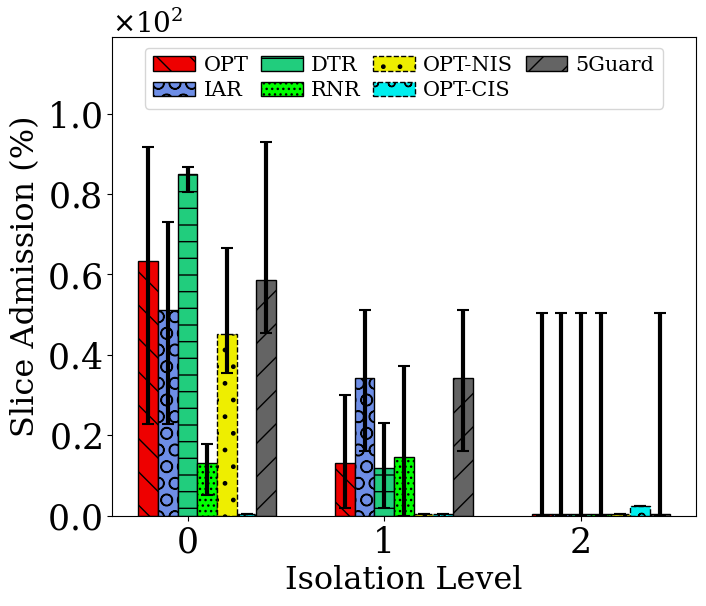

In [84]:
fig, ax = plt.subplots(figsize=(7, 6))
positions = [np.arange(3) + i * bar_width for i in range(len(algs))]

sr_type_list_used = [
    sr_type_list[t]
    for iter in range(ITER)
    for t in range(iter * TOT_SIMULATION_INTERVAL, iter * TOT_SIMULATION_INTERVAL + T_START + SIMULATION_INTERVAL)
]
for i, alg in enumerate(algs):
    NUM_L0_SR = (sr_type_list_used.count(0) + sr_type_list_used.count(2)) / ITER
    NUM_L1_SR = (sr_type_list_used.count(1)) / ITER
    NUM_L2_SR = (sr_type_list_used.count(3)) / ITER
    if alg == 'nis':
        NUM_L0_SR = T_START + SIMULATION_INTERVAL
        NUM_L1_SR = NUM_L2_SR = 0
    elif alg == 'cis':
        NUM_L2_SR = T_START + SIMULATION_INTERVAL
        NUM_L0_SR = NUM_L1_SR = 0
    denominator = np.clip([NUM_L0_SR, NUM_L1_SR, NUM_L2_SR], 1e-9, None)

    values = (1 - np.sum(np.array(ypoints[alg]["reject"]), axis=0) / denominator) * 100
    values = [(min(a, b) + 0.5) for a, b in zip(values, [100, 100, 100])]

    # Extracting error values
    err_low  = values - np.clip(
        list([np.min((1 - np.sum(np.array(data_loaded[alg]["reject"]), axis=1) / denominator), axis=0) * 100])[0] + 0.5, 
        0, None
    )
    err_high = np.clip(
        list([np.max((1 - np.sum(np.array(data_loaded[alg]["reject"]), axis=1) / denominator), axis=0) * 100])[0] + 0.5, 
        0, None
    ) - values

    if alg == 'nis':
        for j in range(1,3):
            values[j]   = 0.5 # For visibility
            err_low[j]  = 0   # For visibility
            err_high[j] = 0   # For visibility
    elif alg == 'cis':
        for j in range(0,2):
            values[j]   = 0.5 # For visibility
            err_low[j]  = 0   # For visibility
            err_high[j] = 0   # For visibility

    # Adding bars with error bars
    ax.bar(positions[i], values, width=bar_width, color=colors[i], edgecolor='black', hatch=patterns[i], linestyle=linestyles[i],
           yerr=[err_low, err_high], capsize=5, error_kw={'elinewidth': 3, 'capthick': 1.5, 'capsize': 4})

ax.set_xticks(positions[2])
ax.set_xticklabels(['0', '1', '2'])
ax.set_ylim(top=119)

ax.tick_params(axis='both', labelsize=tick_label_size)
ax.legend(
    legends,
    fontsize=legend_font_size - 3,
    loc='upper center',
    ncol=4,
    handletextpad=0.4,  # Reduce space between legend marker and text
    columnspacing=0.6,  # Reduce space between columns
    labelspacing=0.3  # Reduce vertical space between rows (not needed if one row)
)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size

ax.set_xlabel(plot_titles[0][0], fontsize=xlabel_font_size)
ax.set_ylabel(plot_titles[0][1], fontsize=ylabel_font_size)
fig.tight_layout(pad=0.5)
plt.savefig(f"plots/result_{0}.svg", format="svg")

## Profit and Cumulative Migration 

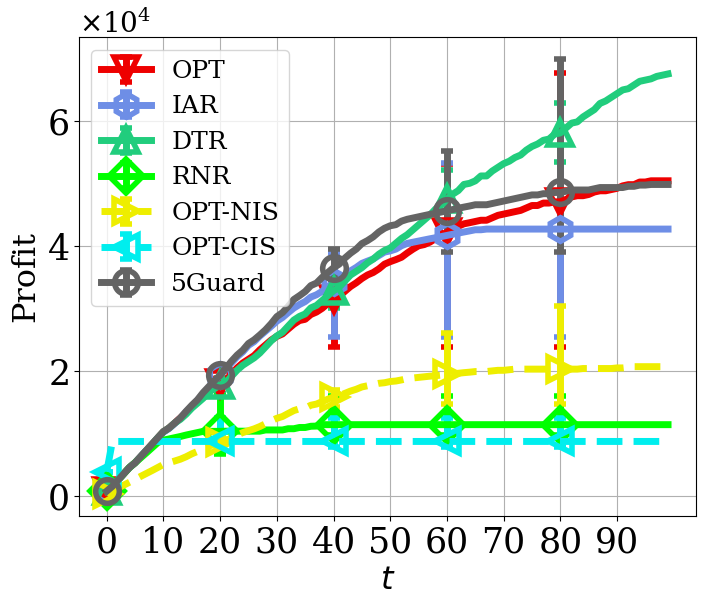

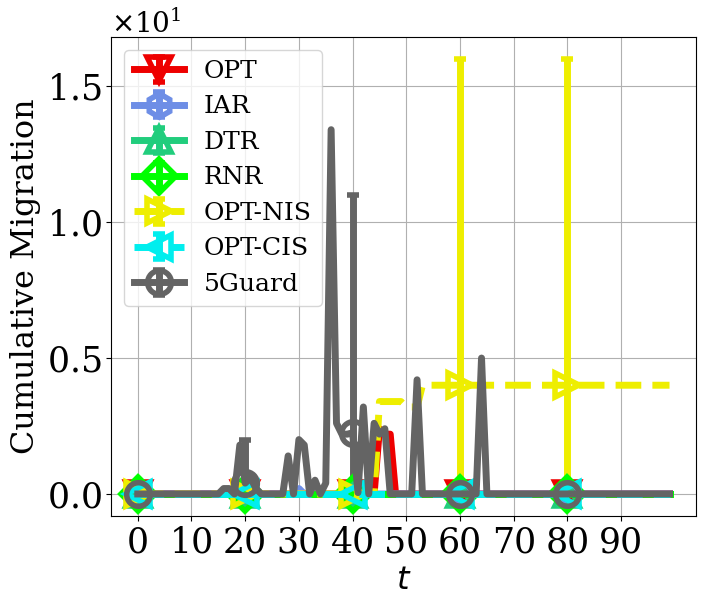

In [87]:
for idx_k, k in enumerate(kpis2):
    fig, ax = plt.subplots(figsize=(7, 6))

    for i, alg in enumerate(algs):
        # # Compute lower and upper bounds for shading
        # lower_bound = ypoints[alg][k] - yerrors_low[alg][k]
        # upper_bound = ypoints[alg][k] + yerrors_high[alg][k]

        # # Add shaded error region (EXCLUDED from legend)
        # ax.fill_between(xpoints, lower_bound, upper_bound, 
        #                 color=colors[i], alpha=0.1, label="_nolegend_")

        # Plot main line with markers
        ax.errorbar(xpoints, ypoints[alg][k],  
                    yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerrors_low[alg][k], np.nan),  
                          np.where(np.arange(len(xpoints)) % step == 0, yerrors_high[alg][k], np.nan)),  
                    marker=markers[i], markevery=markevery, markersize=marker_size,
                    color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
                    markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle=linestyles[i])
    
    ax.grid()
    plt.xticks(np.arange(0, T_START + SIMULATION_INTERVAL, step=10))

    ax.tick_params(axis='both', labelsize=tick_label_size)
    ax.legend(legends, fontsize=legend_font_size)

    # Scientific notation formatting
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
    ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size

    # Labels
    ax.set_xlabel(plot_titles[idx_k + 1][0], fontsize=xlabel_font_size)
    ax.set_ylabel(plot_titles[idx_k + 1][1], fontsize=ylabel_font_size)

    fig.tight_layout(pad=0.5)
    plt.savefig(f"plots/result_{idx_k+1}.svg", format="svg")


## Allocation Time

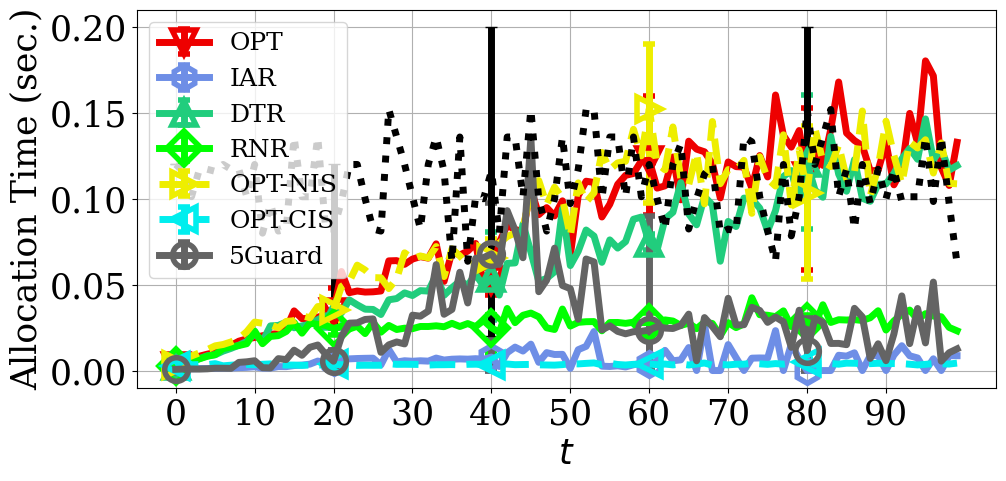

In [90]:
xpoints = range(0, T_START + SIMULATION_INTERVAL)
kpi = "time"
limits = np.array([4, 5, 1, 0.5]) * 0.01

# Plot setup
fig, ax = plt.subplots(figsize=(10, 4.75))

for i, alg in enumerate(algs):
    # # Compute error bounds
    # lower_bound = ypoints[alg][kpi] - yerrors_low[alg][kpi]
    # upper_bound = ypoints[alg][kpi] + yerrors_high[alg][kpi]

    # # Add shaded error region (EXCLUDED from legend)
    # ax.fill_between(xpoints, lower_bound, upper_bound, 
    #                 color=colors[i], alpha=0.1, label="_nolegend_")  

    # Plot the main line with markers
    ax.errorbar(xpoints, ypoints[alg][kpi],  
                yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerrors_low[alg][kpi], np.nan),  
                      np.where(np.arange(len(xpoints)) % step == 0, yerrors_high[alg][kpi], np.nan)),  
                marker=markers[i], markevery=markevery, markersize=marker_size,
                color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
                markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle=linestyles[i])

# Formatting
ax.grid()
ax.tick_params(axis='both', labelsize=25)
ax.legend(legends, fontsize=18)
ax.set_xlabel('$\it{t}$', fontsize=25)
ax.set_ylabel('Allocation Time (sec.)', fontsize=25)
ax.set_xticks(np.arange(0, T_START + SIMULATION_INTERVAL, step=10))

# Add dashed limit lines (uncomment if needed)
# for limit in limits:
#     ax.axhline(y=limit, color='#000000', linestyle='--', linewidth=2)

# Compute timeout statistics
timeout_times = np.zeros((ITER, T_START + SIMULATION_INTERVAL))
for iter in range(ITER):
    for idx_r_t, r_t in enumerate(sr_list[iter * TOT_SIMULATION_INTERVAL : iter * TOT_SIMULATION_INTERVAL + T_START + SIMULATION_INTERVAL]):
        timeout_times[iter][idx_r_t] = r_t.timeout

timeout_times_avg = np.sum(timeout_times, axis=0) / ITER
yerr_low  = timeout_times_avg - np.min(timeout_times, axis=0)
yerr_high = np.max(timeout_times, axis=0) - timeout_times_avg

# # Add timeout error bars with shaded region
# ax.fill_between(xpoints, timeout_times_avg - yerr_low, timeout_times_avg + yerr_high, 
#                 color='#000000', alpha=0.1, label="_nolegend_")

ax.errorbar(xpoints, timeout_times_avg,  
            yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerr_low, np.nan),  
                  np.where(np.arange(len(xpoints)) % step == 0, yerr_high, np.nan)),
            color='#000000', linewidth=linewidth, capsize=4, capthick=1, linestyle=':')

fig.tight_layout(pad=0.5)

# Save & show
plt.savefig("plots/result_8.svg", format="svg")
plt.show()


## Violation, Deployment, and Overhead Costs and Resource Efficiency

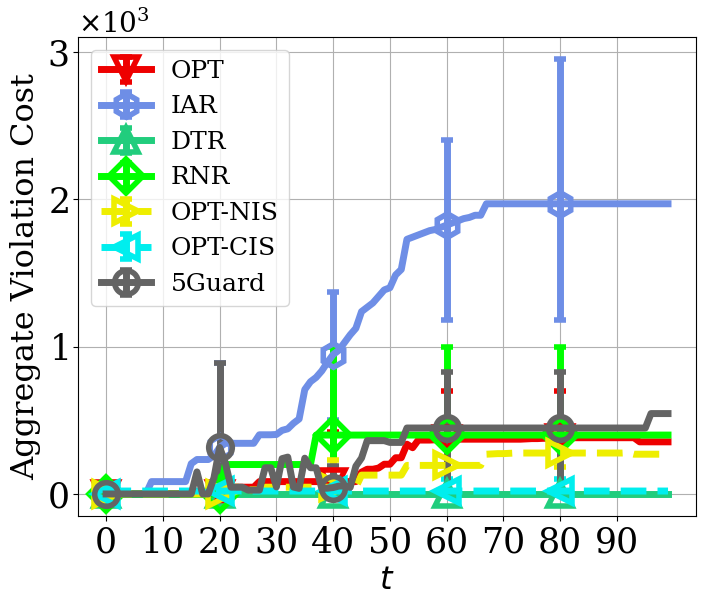

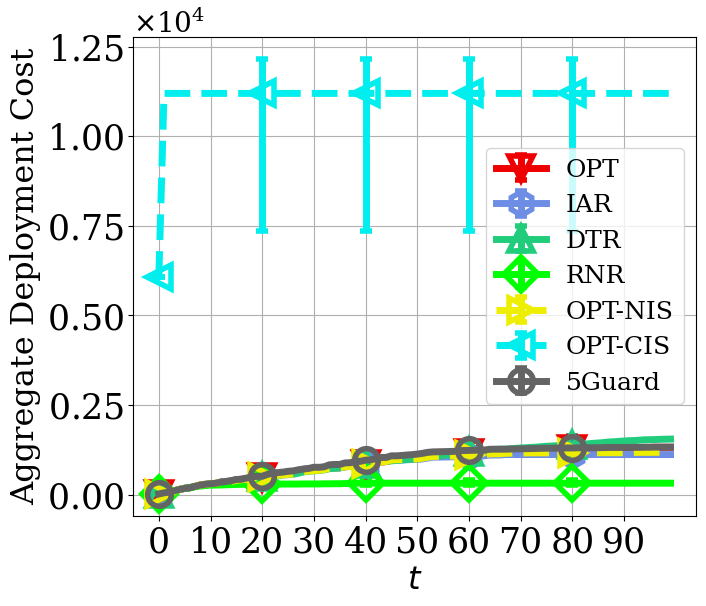

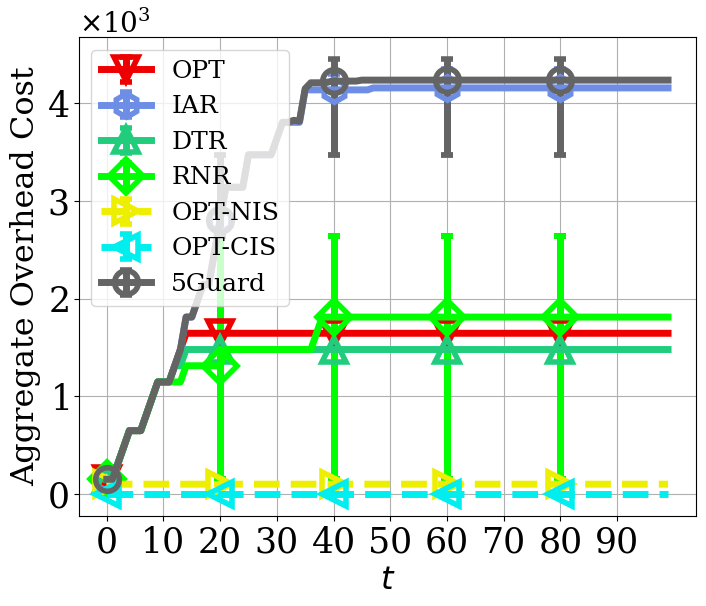

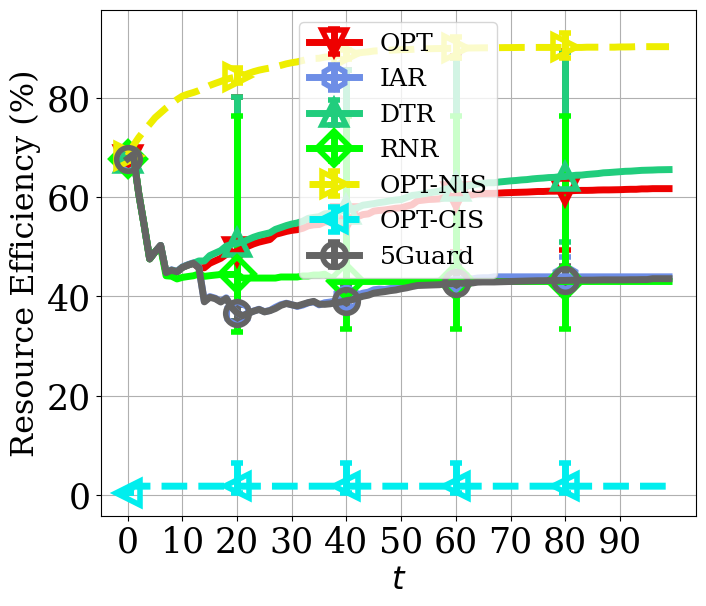

In [93]:
for idx_k, k in enumerate(kpis3):
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for i, alg in enumerate(algs):
        # # Compute error bounds
        # lower_bound = ypoints[alg][k][:, 0] - yerrors_low[alg][k][:, 0]
        # upper_bound = ypoints[alg][k][:, 0] + yerrors_high[alg][k][:, 0]

        # # Add shaded error region (EXCLUDED from legend)
        # ax.fill_between(xpoints, lower_bound, upper_bound, 
        #                 color=colors[i], alpha=0.1, label="_nolegend_")  # No effect on legend

        # Plot the main line with markers and error bars
        ax.errorbar(xpoints, ypoints[alg][k][:, 0],  
                    yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerrors_low[alg][k][:, 0], np.nan),  
                          np.where(np.arange(len(xpoints)) % step == 0, yerrors_high[alg][k][:, 0], np.nan)),  
                    marker=markers[i], markevery=markevery, markersize=marker_size,
                    color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
                    markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle=linestyles[i])
    
    ax.grid()
    
    plt.xticks(np.arange(0, T_START+SIMULATION_INTERVAL, step=10))

    ax.tick_params(axis='both', labelsize=tick_label_size)
    ax.legend(legends, fontsize=legend_font_size)

    if k != "reseff":  # Percentage data
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.get_major_formatter().set_scientific(True)
        ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
        ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size
    
    ax.set_xlabel(plot_titles[idx_k+3][0], fontsize=xlabel_font_size)
    ax.set_ylabel(plot_titles[idx_k+3][1], fontsize=ylabel_font_size)
    fig.tight_layout(pad=0.5)
    plt.savefig(f"plots/result_{idx_k+3}.svg", format="svg")

plt.show()


## Average Isolation Level

In [96]:
def cumulative_average_with_holding(values):
    cumulative_sum = 0
    count = 0
    avg_list = []
    
    for v in values:
        if v != -1:  # Only update sum and count for valid values
            cumulative_sum += v
            count += 1
        avg_list.append(cumulative_sum / count if count > 0 else 0)  # Maintain last valid average

    return avg_list

## Calculating the cumulative average isolation level:
gamma_values        = [{} for iter in range(ITER)]
isol_level          = {}
isol_level_avg      = {}
isol_level_cavg     = {}
isol_level_cavg_avg = {}

algs_isol    = ['nis', 'cis', 'isolation-aware']
for alg in algs_isol:
    for iter in range(ITER):
        gamma_values_iaw  = [0 if type == 0 or type == 2
                                 else (1 if type == 1 else 2)
                                 for type in sr_type_list[iter*TOT_SIMULATION_INTERVAL : iter*TOT_SIMULATION_INTERVAL+T_START+SIMULATION_INTERVAL]
                                ]
        gamma_values[iter][alg] = [0 if alg == 'nis'
                                   else (2 if alg == 'cis'
                                         else gamma_values_iaw[t % TOT_SIMULATION_INTERVAL]
                                        )
                                   for t in range(iter*TOT_SIMULATION_INTERVAL, iter*TOT_SIMULATION_INTERVAL+T_START+SIMULATION_INTERVAL)
                                  ]

    # Compute cumulative average for each algorithm
    isol_level_cavg[alg] = [cumulative_average_with_holding(gamma_values[i][alg]) for i in range(ITER)]
    isol_level[alg]      = [gamma_values[i][alg] for i in range(ITER)]
    
    isol_level_cavg_avg[alg] = np.sum(isol_level_cavg[alg], axis=0) / ITER # Avergae over iterations
    isol_level_avg[alg]      = np.sum(isol_level[alg], axis=0) / ITER # Avergae over iterations

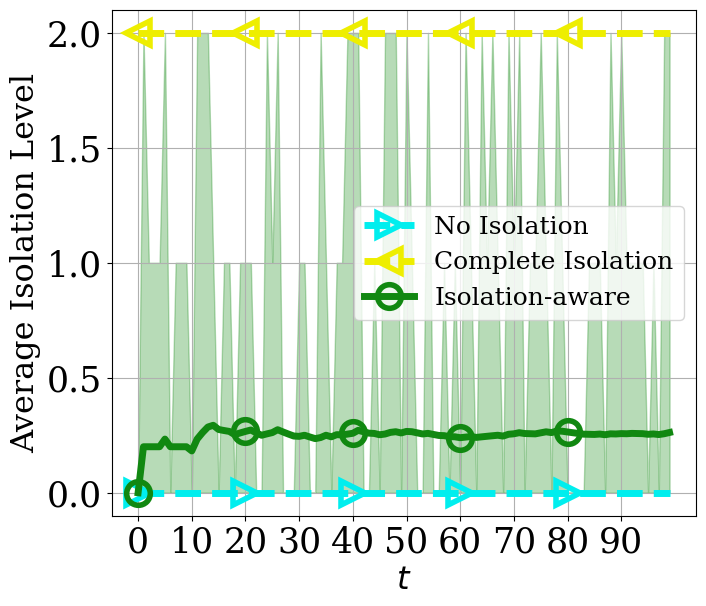

In [98]:
colors_isol     = ["#00EEEE", "#EEEE00", "#118811"]
markers_isol    = ['>', '<', 'o']
linestyles_isol = ['--', '--', '-']
legends_isol    = ['No Isolation', 'Complete Isolation', 'Isolation-aware']

fig, ax   = plt.subplots(figsize=(7, 6))

yerr_low  = {a: isol_level_cavg_avg[a]-np.min(isol_level_cavg[a], axis=0) for a in algs_isol}  # Lower bound errors
yerr_high = {a: np.max(isol_level_cavg[a], axis=0)-isol_level_cavg_avg[a] for a in algs_isol}  # Upper bound errors

for i, alg in enumerate(algs_isol):
    # Compute error bounds
    lower_bound = isol_level_cavg_avg[alg] - yerr_low[alg]
    upper_bound = isol_level_cavg_avg[alg] + yerr_high[alg]

    # Plot the main line with error bars
    ax.errorbar(xpoints, isol_level_cavg_avg[alg],  
                # yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerr_low[alg], np.nan),  
                #       np.where(np.arange(len(xpoints)) % step == 0, yerr_high[alg], np.nan)),  
                marker=markers_isol[i], markevery=markevery, markersize=marker_size,
                color=colors_isol[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors_isol[i],
                markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle=linestyles_isol[i])

    # # Add shaded error region
    # ax.fill_between(xpoints, lower_bound, upper_bound, 
    #                 color=colors_isol[i], alpha=0.1, label="_nolegend_")  # Alpha controls transparency

yerr_low  = isol_level_avg['isolation-aware'] - np.min(isol_level['isolation-aware'], axis=0)  # Lower bound errors
yerr_high = np.max(isol_level['isolation-aware'], axis=0) - isol_level_avg['isolation-aware']  # Upper bound errors

lower_bound = isol_level_avg['isolation-aware'] - yerr_low
upper_bound = isol_level_avg['isolation-aware'] + yerr_high

# ax.errorbar(xpoints, isol_level_avg['isolation-aware'],  
#                 yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerr_low, np.nan),  
#                       np.where(np.arange(len(xpoints)) % step == 0, yerr_high, np.nan)),  
#                 marker='D', markevery=markevery, markersize=marker_size,
#                 color="#118811", linewidth=linewidth, markerfacecolor='none', markeredgecolor="#118811", alpha=0.1,
#                 markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle='--')

# Add shaded error region
ax.fill_between(xpoints, lower_bound, upper_bound, 
                color="#118811", alpha=0.3, label="_nolegend_")  # Alpha controls transparency
ax.grid()

plt.xticks(np.arange(0, T_START+SIMULATION_INTERVAL, step=10))

ax.tick_params(axis='both', labelsize=tick_label_size)
ax.legend(['No Isolation', 'Complete Isolation', 'Isolation-aware'], fontsize=legend_font_size)

if k != "reseff": ## Percentage data
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
    ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size

ax.set_xlabel(plot_titles[7][0], fontsize=xlabel_font_size)
ax.set_ylabel(plot_titles[7][1], fontsize=ylabel_font_size)
fig.tight_layout(pad=0.5)
plt.savefig(f"plots/result_7.svg", format="svg")

plt.show()

## Algorithm Usage in 5Guard

In [101]:
alg_usage = [[0 for _ in range(4)] for _ in range(ITER)]

for iter in range(ITER):
    alg_usage[iter] = [fgr_alg_list[iter].count(a) / (T_START+SIMULATION_INTERVAL) * 100 for a in range(4)]

alg_usage_avg = np.sum(alg_usage, axis=0) / ITER

yerr_low  = np.array(alg_usage_avg - np.min(alg_usage, axis=0))  # Lower bound errors
yerr_high = np.array(np.max(alg_usage, axis=0) - alg_usage_avg)   # Upper bound errors

yerr      = np.array([yerr_low, yerr_high])  # Correct format

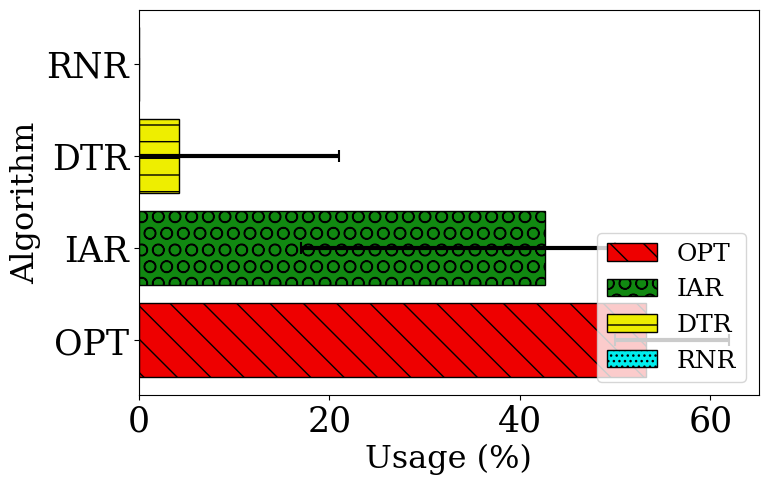

In [103]:
# Data
categories = ['OPT', 'IAR', 'DTR', 'RNR']
values     = [10, 15, 7, 12]  # Example values

# Colors for bars
colors = ["#EE0000", "#118811", "#EEEE00", "#00EEEE"]
patterns = ['\\', 'O', '-', '...']

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Create horizontal bars
bars = ax.barh(categories, alg_usage_avg, xerr=yerr, color=colors, hatch=patterns, edgecolor='black', 
               capsize=5, error_kw={'elinewidth': 3, 'capthick': 1.5, 'capsize': 4}
              )

# Add legend
ax.legend(bars, categories, loc='lower right', fontsize=legend_font_size)

# Labels
ax.set_xlabel("Usage (%)", fontsize=xlabel_font_size)
ax.set_ylabel("Algorithm", fontsize=ylabel_font_size)

ax.tick_params(axis='both', labelsize=tick_label_size)

# Show the chart
plt.show()